# Overview

This notebook explores how a single head transformer does sorting.

In [1]:
!pip install transformer_lens > /dev/null

In [2]:
from random import sample
import torch

mid_id = 0
low = 2
high = 20
size = 5

def generate_sequence_prefix(low, high, size):
  return sample(range(low,high+1),size)

def generate_sequence(low, high, size):
  sequence = generate_sequence_prefix(low, high, size)
  sequence = sequence + [mid_id] + sorted(sequence)
  return sequence

def generate_sequences(low=low, high=high, size=9, count=50000):
  res = []
  for i in range(count):
    res.append(torch.tensor(generate_sequence(low, high, size)))
  return res


def test_sequence_coverage(test, train):
  train_set = set(tuple(s) for s in train)
  test_set = set(tuple(s) for s in test)

  return len(train_set.intersection(test_set)) / len(test_set)

In [3]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, low=low,high=high,size=5,count=5):
        self.data= generate_sequences(low=low, high=high, size=size, count=count)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        return {"tokens": item}

In [4]:
from transformers import PreTrainedTokenizer
from transformer_lens import HookedTransformer, HookedTransformerConfig

vocab_size = high - low + 3

cfg = HookedTransformerConfig(
    n_layers = 1,
    d_model = 16,
    n_ctx = size * 2 + 1,
    d_head = 16,
    d_vocab = vocab_size,
    d_vocab_out = vocab_size,
    act_fn = 'relu'
)

In [5]:
from dataclasses import dataclass
from typing import Optional

import torch
import torch.optim as optim
import wandb
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

from transformer_lens import HookedTransformer, utils
from transformer_lens.train import HookedTransformerTrainConfig

from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union, cast
from jaxtyping import Float, Int

def lm_accuracy(
    logits: Float[torch.Tensor, "batch pos d_vocab"],
    tokens: Int[torch.Tensor, "batch pos"],
    per_example: bool = True,
) -> Union[Float[torch.Tensor, ""], Float[torch.Tensor, "batch pos"]]:
    """Cross-Entropy Accuracy for Language Modelling. We measure the accuracy on the logits for predicting the NEXT token.

    If per_token is True, returns the boolean for top 1 accuracy for each token in the batch. Note that this has size [batch, seq_len-1], as we cannot predict the first token.
    """
    top_prediction = logits.argmax(dim=-1)
    correct_matches = top_prediction[:, :-1] == tokens[:, 1:]
    if per_example:
        example_accuracies = correct_matches.min(dim=-1).values
        return example_accuracies.sum() / example_accuracies.numel()
    else:
        return correct_matches.sum() / correct_matches.numel()


def train(
    model: HookedTransformer,
    config: HookedTransformerTrainConfig,
    dataset: Dataset,
    test_dataset: Dataset,
) -> HookedTransformer:
    """
    Trains an HookedTransformer model on an autoregressive language modeling task.
    Args:
        model: The model to train
        config: The training configuration
        dataset: The dataset to train on - this function assumes the dataset is set up for autoregressive language modeling.
    Returns:
        The trained model
    """
    torch.manual_seed(config.seed)
    model.train()
    if config.wandb:
        if config.wandb_project_name is None:
            config.wandb_project_name = "easy-transformer"
        wandb.init(project=config.wandb_project_name, config=vars(config))

    if config.device is None:
        config.device = utils.get_device()

    if config.optimizer_name in ["Adam", "AdamW"]:
        # Weight decay in Adam is implemented badly, so use AdamW instead (see PyTorch AdamW docs)
        if config.weight_decay is not None:
            optimizer = optim.AdamW(
                model.parameters(),
                lr=config.lr,
                weight_decay=config.weight_decay,
            )
        else:
            optimizer = optim.Adam(
                model.parameters(),
                lr=config.lr,
            )
    elif config.optimizer_name == "SGD":
        optimizer = optim.SGD(
            model.parameters(),
            lr=config.lr,
            weight_decay=config.weight_decay
            if config.weight_decay is not None
            else 0.0,
            momentum=config.momentum,
        )
    else:
        raise ValueError(f"Optimizer {config.optimizer_name} not supported")

    scheduler = None
    if config.warmup_steps > 0:
        scheduler = optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda step: min(1.0, step / config.warmup_steps),
        )

    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True)

    model.to(config.device)

    batches = []
    losses = []
    accuracies = []
    predictions = []

    test_losses = []
    test_accuracies = []

    for epoch in tqdm(range(1, config.num_epochs + 1)):
        samples = 0
        for step, (batch, test_batch) in enumerate(zip(dataloader, test_dataloader)):
            tokens = batch["tokens"].to(config.device)

            loss = model(tokens, return_type="loss")
            logits = model(tokens, return_type="logits")

            prediction = model(tokens)
            predictions.append(prediction)

            test_tokens = test_batch["tokens"].to(config.device)

            test_loss = model(test_tokens, return_type="loss")
            test_logits = model(test_tokens, return_type="logits")

            loss.backward()
            if config.max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            optimizer.step()
            if config.warmup_steps > 0:
                assert scheduler is not None
                scheduler.step()
            optimizer.zero_grad()

            samples += tokens.shape[0]

            if config.wandb:
                wandb.log(
                    {"train_loss": loss.item(), "samples": samples, "epoch": epoch}
                )

            accuracy = lm_accuracy(logits[:,size+1:,:], tokens[:,size+1:])
            test_accuracy = lm_accuracy(test_logits[:,size+1:,:], test_tokens[:,size+1:])

            if epoch == config.num_epochs:
              batches.append(batch)
              accuracies.append(accuracy.item())
              losses.append(loss.item())
              test_accuracies.append(test_accuracy.item())
              test_losses.append(test_loss.item())

            if config.print_every is not None and step % config.print_every == 0:
                print(f"epoch {epoch} samples {samples} step {step} loss {loss.item()}")

            if (
                config.save_every is not None
                and step % config.save_every == 0
                and config.save_dir is not None
            ):
                torch.save(model.state_dict(), f"{config.save_dir}/model_{step}.pt")

            if config.max_steps is not None and step >= config.max_steps:
                break

    return model, {
        'losses': losses,
        'accuracies': accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'batches': batches,
        'predictions' : predictions,
    }

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numbers(*numbers):
    # Set the Seaborn style
    sns.set(style="darkgrid")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ["blue", "red"]

    for color, number in zip(colors, numbers):
      # Plot the numbers as a line graph
      sns.lineplot(x=range(len(number)), y=number, ax=ax, color=color, linewidth=2)

    # Set the title and labels
    ax.set_title("Number Graph", fontsize=16)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)

    # Rotate the x-axis labels if needed
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()



In [7]:
from collections import defaultdict

def make_save_hook_func():
  hook_values = []

  def save_value_hook(value, hook):
    hook_values.append(value)

  return save_value_hook, hook_values

In [8]:
dataset = MyDataset(low=low, high=high, size=size, count=2000)
test_dataset = MyDataset(low=low, high=high, size=size, count=2000)

print(test_sequence_coverage(test_dataset.data, dataset.data))

0.0


In [9]:
model = HookedTransformer(
    cfg=cfg,
)

model.reset_hooks()

# Access the attention scores for each block
attn_score_hook, attn_score_hook_values = make_save_hook_func()
model.blocks[0].attn.hook_attn_scores.add_hook(attn_score_hook)

value_score_hook, value_score_hook_values = make_save_hook_func()
model.blocks[0].hook_resid_post.add_hook(value_score_hook)

train_cfg = HookedTransformerTrainConfig(
    batch_size = 250,
    num_epochs = 100,
    lr = 1e-3
)

model, aux = train(
    model=model,
    config=train_cfg,
    dataset=dataset,
    test_dataset=test_dataset
)

Moving model to device:  cuda


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1 samples 250 step 0 loss 3.213412046432495
epoch 2 samples 250 step 0 loss 3.064371347427368
epoch 3 samples 250 step 0 loss 2.972081422805786
epoch 4 samples 250 step 0 loss 2.8760807514190674
epoch 5 samples 250 step 0 loss 2.7837960720062256
epoch 6 samples 250 step 0 loss 2.6947994232177734
epoch 7 samples 250 step 0 loss 2.620619773864746
epoch 8 samples 250 step 0 loss 2.5452630519866943
epoch 9 samples 250 step 0 loss 2.4773850440979004
epoch 10 samples 250 step 0 loss 2.438835382461548
epoch 11 samples 250 step 0 loss 2.3990976810455322
epoch 12 samples 250 step 0 loss 2.3574626445770264
epoch 13 samples 250 step 0 loss 2.3360049724578857
epoch 14 samples 250 step 0 loss 2.3216381072998047
epoch 15 samples 250 step 0 loss 2.292340040206909
epoch 16 samples 250 step 0 loss 2.2465529441833496
epoch 17 samples 250 step 0 loss 2.2326931953430176
epoch 18 samples 250 step 0 loss 2.211273431777954
epoch 19 samples 250 step 0 loss 2.1731061935424805
epoch 20 samples 250 step 0 

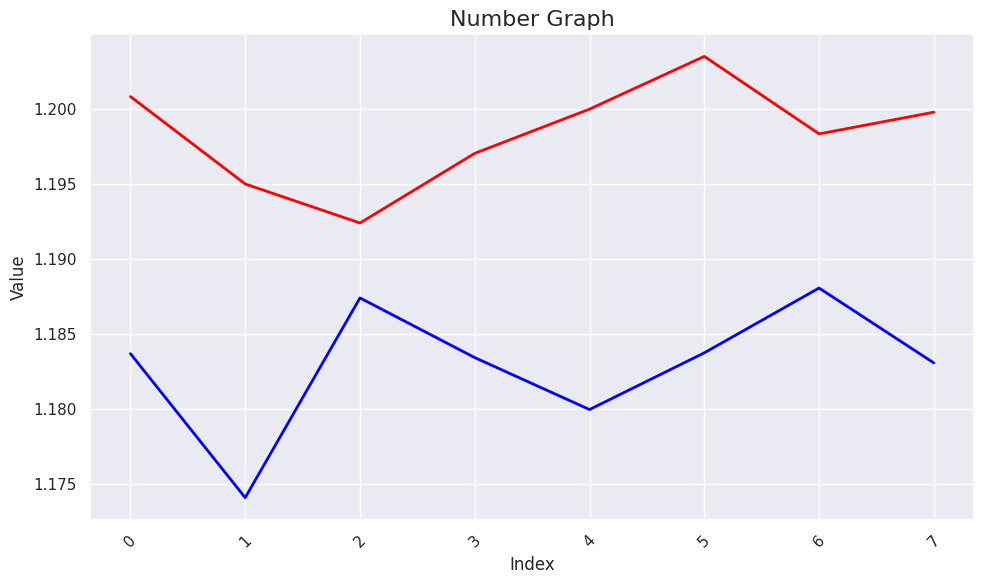

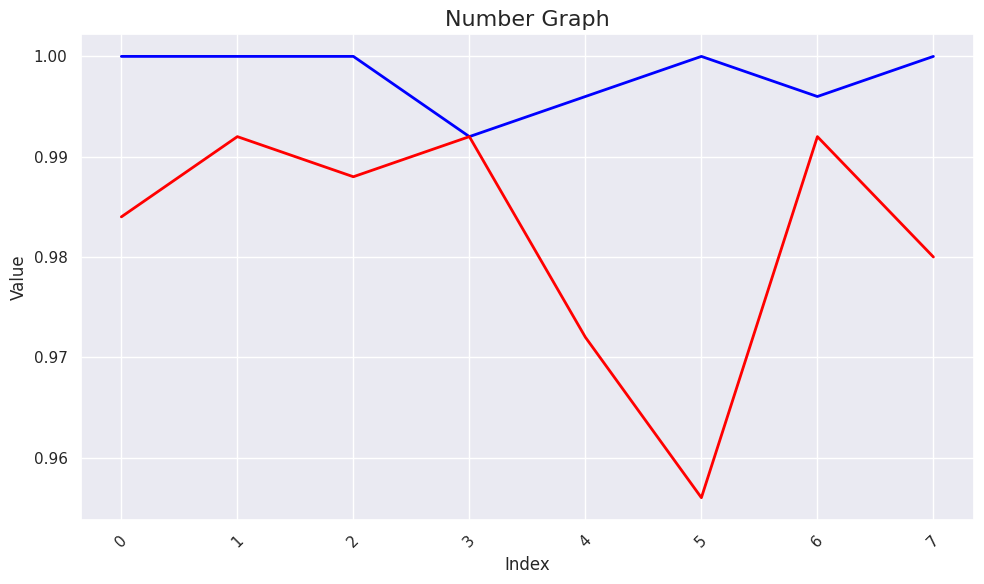

In [10]:
plot_numbers(aux["losses"], aux["test_losses"])
plot_numbers(aux["accuracies"], aux["test_accuracies"])

In [11]:
print(model)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre)

[19 12 11 16  0  5  7  8 18 20 10]
[8, 7, 20, 5, 18, 0, 5, 7, 8, 18, 20]
index:1 prediction:7 first_index:2
index:2 prediction:20 first_index:3
index:3 prediction:5 first_index:4
index:4 prediction:18 first_index:5
index:5 prediction:0 first_index:6
index:6 prediction:5 first_index:4
index:7 prediction:7 first_index:2
index:8 prediction:8 first_index:1
index:9 prediction:18 first_index:5
index:10 prediction:20 first_index:3


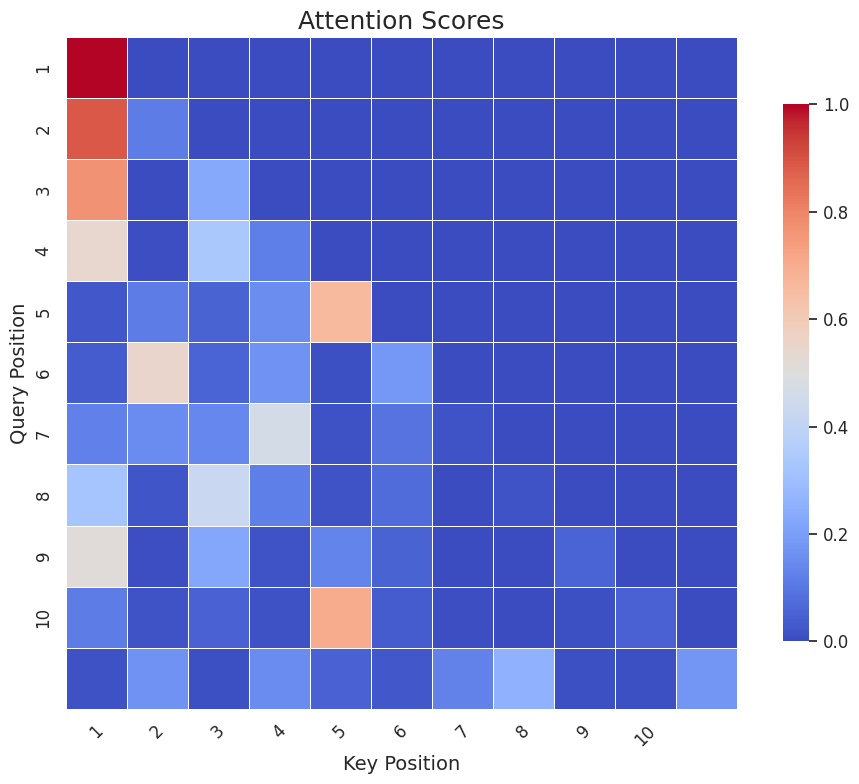

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

hook_values = attn_score_hook_values
sample_choice = 15

# Replace -inf values with a placeholder value (e.g., the minimum finite value)
attention_scores = hook_values[-1][sample_choice,0,:,:].cpu().detach().numpy()
attention_scores = softmax(attention_scores, axis=-1)
score_data = aux["batches"][-1]["tokens"][sample_choice].cpu().detach().numpy().tolist()

print(np.argmax(softmax(aux["predictions"][-1][sample_choice].cpu().detach().numpy(),axis=-1),axis=-1))

print(score_data)
for index, entry in enumerate(score_data[:-1], start=1):
  print(f"index:{index} prediction:{score_data[index]} first_index:{score_data.index(score_data[index])+1}")

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Plot the heatmap
sns.heatmap(attention_scores, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Set the title and labels
ax.set_title("Attention Scores", fontsize=18)
ax.set_xlabel("Key Position", fontsize=14)
ax.set_ylabel("Query Position", fontsize=14)

# Set the tick labels
ax.set_xticks(np.arange(0.5, size * 2 + .5, 1))
ax.set_yticks(np.arange(0.5, size * 2 + .5, 1))
ax.set_xticklabels(np.arange(1, size * 2 + 1), fontsize=12)
ax.set_yticklabels(np.arange(1, size * 2 + 1), fontsize=12)

# Rotate the x-tick labels
plt.xticks(rotation=45)


# Add a colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# integers from 0 - 9 [inclusive]
# <mid> token, <padding> token, positional embeddings, no start token, no end token
# fixed length
# 8 tokens -> mid token -> decode 8 tokens
# embedding table maps each of our tokens to an embedding (learned) -> first layer
# generate random sequences -> compute second half based on first half
# see how fast we can train a thing and use that to determine how many examples (fast iteration - 5s / actual experiments 5min)
#

In [14]:
"""
dataloader = DataLoader(dataset, batch_size=train_cfg.batch_size, shuffle=True)
model.to(train_cfg.device)
single_example = next(iter(dataloader))
tokens = single_example["tokens"].to(train_cfg.device)
logits = model(tokens, return_type="logits")

print(single_example)
logits
"""

'\ndataloader = DataLoader(dataset, batch_size=train_cfg.batch_size, shuffle=True)\nmodel.to(train_cfg.device)\nsingle_example = next(iter(dataloader))\ntokens = single_example["tokens"].to(train_cfg.device)\nlogits = model(tokens, return_type="logits")\n\nprint(single_example)\nlogits\n'